In [1]:
import os
import pickle
import numpy as np
from text_processing_utils import *
import glob
import datetime as dt
import math
from variational_inference_sLDA_M_step_diagnostics import *
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
start_time = dt.datetime.now()

#### Prepare the data

Those input data were created by running the Jupyter Notebook "processing_movie_reviews_rating_scale_data.ipynb".

In [2]:
cleaned_ratings = np.array(pickle.load(open("data/scaledata/cleaned_ratings.pickle", "rb")))
cleaned_reviews = pickle.load(open("data/scaledata/cleaned_reviews.pickle", "rb"))
vocabulary_dict = pickle.load(open("data/scaledata/vocabulary_dict.pickle", "rb"))

In [3]:
# randomly split the movie reviews data into training/testing parts (10:90)
np.random.seed(54321)
training_set_ratio = 0.1 # for demonstration purposes, we randomly take a very small training sample
train_indices = np.random.choice(np.arange(len(cleaned_ratings)), int(len(cleaned_ratings)*training_set_ratio), replace=False)
test_indices = np.setdiff1d(np.arange(len(cleaned_ratings)), train_indices)
print(len(train_indices), len(test_indices))
train_bow = convert_bow([cleaned_reviews[i] for i in train_indices])
test_bow = convert_bow([cleaned_reviews[i] for i in test_indices])
train_y = cleaned_ratings[train_indices]
test_y = cleaned_ratings[test_indices]

500 4506


#### Train sLDA model on movie rating data using batch variational inference

In [4]:
K = 12 # number of topics
V = len(vocabulary_dict) # vocabulary size

In [ ]:
## initialization
np.random.seed(12345)
new_alpha = np.array([1/K]*K)
new_xi = np.array([1/V]*V)
new_eta = np.linspace(-1,1,K)
new_delta = np.var(train_y, ddof=1)
new_Lambda = np.abs(np.random.normal(loc=0, scale=0.1, size=K*V)).reshape((K,V)) # initialize Lambda randomly (add a small half-normal distribution to 1)
input_data_x = train_bow
input_data_y = train_y
fpath = "fragmented_output_files/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    delete_all_files(fpath[:-1]) # if the directory exists, we delete all temporary files in it
epsilon = 1e-5 # stopping criteria for convergence in both E and M steps
predict = False
## Run batch mode variational EM
elbo_vs_time = [-math.inf]
improve_in_elbo = math.inf
time_elapsed = 0
j = 0
while improve_in_elbo > 0.01: # We consider the variational EM procedure converges when the improvement in corpus-level elbo becomes smaller than 0.01%

    ### Run one iteration of E step (parallelized)
    %run -i "parallelized_sLDA_E_step.py"
    all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
    new_gamma_dict = merge_dict(all_gamma)
    new_gamma = create_gamma_matrix(new_gamma_dict)
    all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
    new_phi = merge_dict(all_phi)

    ### Run one iteration of M step
    m_step = batch_VI_sLDA_M_Step(K, train_bow, train_y,
                                  new_alpha, new_xi, new_eta, new_delta, new_Lambda,
                                  new_gamma, new_phi,
                                  len(train_bow), epsilon,
                                  closed_form = False)
    new_Lambda, new_alpha, new_xi, new_eta, new_delta, new_elbo = m_step.run()
    improve_in_elbo = pct_diff(elbo_vs_time[-1], new_elbo)
    elbo_vs_time.append(new_elbo)
    current_time = dt.datetime.now()
    time_elapsed = (current_time - start_time).seconds
    j += 1
    print("Complete variational EM iteration {}: ELBO =".format(j), new_elbo)

## save final results to disk
output_dir = "batch_VI_sLDA_movie_rating/K_{}".format(K)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for var in ['Lambda', 'alpha', 'xi', 'eta', 'delta']: # save all global parameters
    pickle.dump(eval("new_"+var), open(output_dir + "/{}.pickle".format(var), "wb"))
pickle.dump(elbo_vs_time, open(output_dir + "/{}.pickle".format("elbo_vs_time"), "wb"))
pickle.dump(time_elapsed, open(output_dir + "/{}.pickle".format("time_elapsed"), "wb"))

0.06250000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
Complete variational EM iteration 1: ELBO = -1068799.9953784943
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
Complete variational EM iteration 2: ELBO = -872113.6606397629
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
0.5000000000000001
Complete variational EM iteration 3: ELBO = -817782.9142847061
0.5000000000000001
0.500000000

In [ ]:
print("Time used to fit the sLDA model:", int(time_elapsed / 60), "minutes")

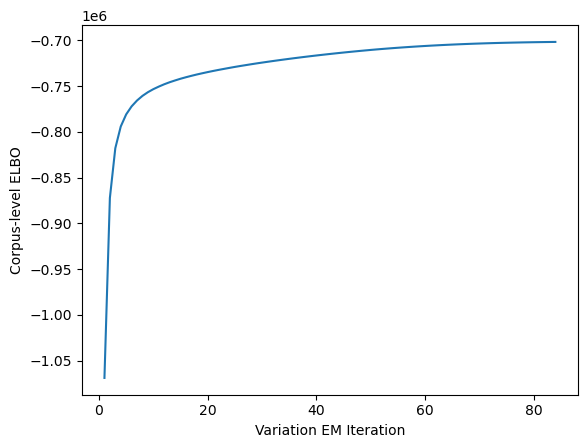

In [7]:
plt.plot(np.arange(1, len(elbo_vs_time)), elbo_vs_time[1:])
plt.xlabel("Variation EM Iteration")
plt.ylabel("Corpus-level ELBO")
plt.show()

In [8]:
# Top  words of each topic learned from training sLDA, with its corresponding coefficient (eta)
top_n = 10 # Top n words from each topic
inverse_vocabulary_dict = {v:k for k,v in vocabulary_dict.items()}
for t in range(K):
    word_indices = np.argsort(new_Lambda[t,:])[::-1][:top_n]
    print("Topic {}:".format(t+1), [inverse_vocabulary_dict[j] for j in word_indices], "eta =", new_eta[t])

Topic 1: ['us', 'especially', 'screen', 'long', 'another', 'over', 'perhaps', 'fact', 'last', 'becomes'] eta = 0.3523859430483009
Topic 2: ['movies', 'violence', 'world', 'cast', 'sex', 'where', 'comes', 'effects', 'michael', 'language'] eta = 0.49357243859371414
Topic 3: ['hard', 're', 'line', 'r', 'every', 'great', 'style', 'sure', 'subject', 'said'] eta = 0.43694323548491915
Topic 4: ['year', 'nothing', 'quite', 'interesting', 'plays', 'full', 'watch', 'tale', 'clear', 'robert'] eta = 0.36661228665772283
Topic 5: ['both', 'role', 'less', 'david', 'through', 'own', 'cinematography', 'yet', 'sometimes', 'half'] eta = 0.9700807425530419
Topic 6: ['action', 'star', 'big', 'actually', 'right', 'moments', 'going', 'result', 'certainly', 'watching'] eta = 1.109954845215512
Topic 7: ['kids', 'motion', 'minutes', 'play', 'however', 'thought', 'together', 'pictures', 'fine', 'once'] eta = 0.7461253285542859
Topic 8: ['special', 'effective', 'age', 'humor', 'everything', 'three', 'production',

#### Prediction and Evaluation on the Test Set

In [27]:
input_data_x = test_bow
input_data_y = test_y
fpath = "fragmented_output_files_new/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    for fn in glob.glob(fpath + "*"):
        os.remove(fn)
epsilon = 1e-4 # stopping criteria for convergence in E step
predict = True # prediction mode for evaluating the test set

## Run one iteration of unsupervised E step (parallelized) to identify the optimal local variational parameters for all documents in the test set.
## The optimized phi identified from the unsupervised batch VI will be used to generate the predictions for response variable y in the test set
%run -i "parallelized_sLDA_E_step.py" # unsupervised batch VI for sLDA is way faster than supervised one
all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
new_gamma_dict = merge_dict(all_gamma)
new_gamma = create_gamma_matrix(new_gamma_dict)
all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
new_phi = merge_dict(all_phi)

In [28]:
# Generate predictions for the response variable y for the test set:
# For Gaussian response, y_hat = E[phi_bar^T eta]
phi_bar = {k:v.mean(axis=0) for k,v in new_phi.items()}
pred_y = np.empty((len(test_y),))
for indx in range(len(test_y)):
    pred_y[indx] = np.dot(phi_bar[indx], new_eta)

In [29]:
# performance metrics: 
def predictive_R2(test_y, pred_y):
    return 1 - np.mean((test_y - pred_y)**2) / np.var(test_y)

print("Predictive R^2 =", predictive_R2(test_y, pred_y))
print("Pearson correlation coefficient =", pearsonr(test_y, pred_y).statistic)

Predictive R^2 = 0.01016739583047599
Pearson correlation coefficient = 0.11927797659064812


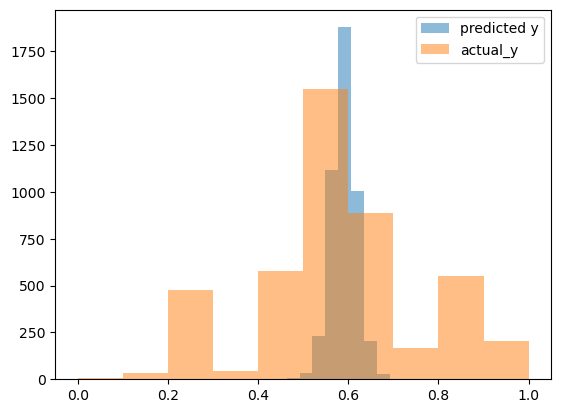

In [32]:
# Compare the predicted histogram of predicted vs. actual y values 
plt.hist(pred_y, alpha=0.5, label='x')
plt.hist(test_y, alpha=0.5, label='y')
plt.legend(['predicted y', 'actual_y'], loc='upper right')
plt.show()